# Algo de pacing complet (meta class)

L'objectif est de réimplémenter l'algo de Pacing complet à l'aide d'une méta class qui gère elle même ses instances selon les dimensions dans lesquelles on veut répartir le budget.
L'idée est de rentrer un dictionnaire de clés qui contient les dimensions du Pacing et on associe une instance à chaque clé. 

### Pacing class

In [1]:
from datetime import datetime
from datetime import timedelta
import pandas as pd
import pytz
import itertools
from statsmodels.formula.api import ols
from loguru import logger
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [2]:
class Pacing:
    """ The pacing algorithm class
    """

    def __init__(self, total_budget, start_date, end_date, timezone):
        """Class constructor"""
        # Raise errors in parameters
        if total_budget < 0:
            raise ValueError("Budget cannot be negative!")
        if start_date > end_date:
            raise ValueError("Start date cannot be later than end date!")

        # Fixed attributes
        self.tz = pytz.timezone(timezone)
        self.start_date = self.tz.localize(start_date)
        self.end_date = self.tz.localize(end_date + timedelta(days=1))
        self.total_days = (self.end_date - self.start_date).days
        self.building = list()
        # Impossible day and hour to initialize the setup
        self.day = 0
        self.total_budget = total_budget
        self.remaining_budget = self.total_budget
        self.engaged_budget = 0
        self.spent_budget = 0

    @staticmethod
    def gen_prop_lr(br_object):
        """Linear regression with hours and weekdays"""
        aggr = br_object.imps.groupby([br_object.index.date, br_object.index.weekday, br_object.index.hour]).sum()
        aggr.index.names = ['date', 'weekday', 'hour']
        aggr = aggr.reset_index()
        model = ols('imps ~ C(weekday) + C(hour)', data=aggr).fit()
        weekday_list = range(7)
        weekday_list = list(itertools.chain.from_iterable(itertools.repeat(x, 24) for x in weekday_list))
        hour_list = list()
        for i in range(7):
            for z in range(24):
                hour_list.append(z)
        df_fitting = pd.DataFrame({'weekday': weekday_list, 'hour': hour_list})
        prediction = model.predict(df_fitting)
        df_fitting['fitted'] = prediction
        pattern = df_fitting.pivot_table('fitted', index=df_fitting.hour, columns=df_fitting.weekday)
        line, col = pattern.shape
        for i in range(col):
            pattern.iloc[:, i] = pattern.iloc[:, i] * 100 / pattern.iloc[:, i].sum()
        return pattern

    @staticmethod
    def gen_prop_lr_hour(br_object):
        """Linear regression with only hours"""
        aggr = br_object.imps.groupby([br_object.index.date, br_object.index.hour]).sum().reset_index()
        aggr.columns = ['date', 'hour', 'imps']
        model = ols('imps ~ C(hour)', data=aggr).fit()
        hour_list = list()
        for z in range(24):
            hour_list.append(z)
        df_fitting = pd.DataFrame({'hour': hour_list})
        prediction = model.predict(df_fitting)
        df_fitting['fitted'] = prediction
        df_fitting.index = df_fitting.hour
        del df_fitting['hour']
        df_fitting.iloc[:, 0] = df_fitting.iloc[:, 0] * 100 / df_fitting.iloc[:, 0].sum()
        return df_fitting

    def meta_prop(self, data):
        """ Give the proportion of impressions per hour. The output type depends on the input.

        :param data: a dataframe with a datetime as index
        :return: an  integer, a Serie or a Dataframe
        """
        if data.empty:
            unif = True
            without_weekday = True
            prop = 1 / 24
        elif set(data.index.hour.unique()) != set(range(24)):
            unif = True
            without_weekday = True
            prop = 1 / 24
        else:
            if set(data.index.weekday.unique()) != set(range(7)):
                unif = False
                without_weekday = True
                prop = self.gen_prop_lr_hour(data)
            else:
                unif = False
                without_weekday = False
                prop = self.gen_prop_lr(data)
        return prop, unif, without_weekday

    def day_reset(self, ts):
        """ Reset variables when there is a new day
        """
        day = ts.day
        month = ts.month
        year = ts.year
        remaining_days = (self.end_date - ts).days + 1  # +1 because biased calculation of days
        if not self.building:
            self.building_data = pd.DataFrame.from_records(self.building)
        else:
            self.building_data = pd.DataFrame.from_records(self.building, index='Date')
        self.current_hour = -1
        self.remaining_budget_hour = 0
        self.daily_budget = self.remaining_budget / remaining_days
        self.surplus_hour = 0
        self.BT = [0]
        self.acceleration = [{'ts': self.tz.localize(datetime(year, month, day, 0, 0, 0)),
                              'A': 0}]
        self.speed = [{'ts': self.tz.localize(datetime(year, month, day, 0, 0, 0)),
                       'S': 0}]
        self.size_acceleration = 1
        self.sum_acceleration = 0
        self.size_speed = 1
        self.sum_speed = 0
        self.prop_table, self.unif, self.without_weekday = self.meta_prop(self.building_data)

    def hour_reset(self, weekday):
        """ Reset budget for the following hour
        """
        self.current_hour += 1
        self.remaining_hours = 24 - self.current_hour
        # Evolutive target
        self.surplus_hour += self.remaining_budget_hour / self.remaining_hours
        if self.unif:
            self.budget_hour = (self.prop_table * self.daily_budget) + self.surplus_hour
        elif self.without_weekday and not self.unif:
            self.budget_hour = (self.prop_table.iloc[
                                    self.current_hour, 0] / 100) * self.daily_budget + self.surplus_hour
        else:
            self.budget_hour = (self.prop_table.iloc[
                                    self.current_hour, weekday] / 100) * self.daily_budget + self.surplus_hour
        self.target = self.budget_hour / 3600
        self.spent_hour = 0
        self.remaining_budget_hour = self.budget_hour - self.spent_hour

    def gen_mean(self, mean_type):
        """ Return the average variation and speed of variation for bt
        """
        created_time = self.acceleration[-1]['ts'] - timedelta(minutes=30)
        if mean_type == 'acceleration':
            while self.acceleration[0]['ts'] < created_time:
                self.size_acceleration -= 1
                self.sum_acceleration += self.acceleration[0]['A']
                del self.acceleration[0]
            try:
                average = self.sum_acceleration / self.size_acceleration
            except ZeroDivisionError:
                average = 0
        else:
            while self.speed[0]['ts'] < created_time:
                self.size_speed -= 1
                self.sum_speed += self.speed[0]['S']
                del self.speed[0]
            try:
                average = self.sum_speed / self.size_speed
            except ZeroDivisionError:
                average = 0
        return average

    def build_data_prop(self, ts, imps):
        self.building.append({'Date': ts, 'imps': imps})

    def bt_calculation(self, average_acceleration, average_speed, remaining_time, coef=1):
        """ Return the per second budget
        """
        alpha = average_acceleration * coef
        try:
            bt = self.remaining_budget_hour * ((1 + alpha * average_speed) / remaining_time)
        except ZeroDivisionError:
            bt = 1
        if bt < 0:
            bt = 1
        return bt

    def buying_decision(self, ts, price, imps):
        """From a BR, decide whether to buy or not

        :param ts: timestamp of the BR
        :param price: price of the BR
        :param imps: number of impressions
        :return: Boolean
        """

        # Check problem in br
        if price < 0:
            return False
        if imps < 0:
            return False

        # TS de la BR
        weekday = ts.weekday()
        day = ts.day
        month = ts.month
        year = ts.year
        hour = ts.hour

        # If we begin a new day, we reset variables
        if self.day != day:
            self.day_reset(ts)
        self.day = day

        # Changement of hour
        while hour != self.current_hour:
            self.hour_reset(weekday)

        # Build data for proportion lr
        self.build_data_prop(ts, imps)

        # Remaining time before the end of the hour
        end_hour = self.tz.localize(datetime(year, month, day, hour, 59, 59, 999999))
        remaining_time = datetime.timestamp(end_hour) + 10 - datetime.timestamp(ts)

        # Calculation of bt
        average_acceleration = self.gen_mean('acceleration')
        average_speed = self.gen_mean('speed')
        self.bt = self.bt_calculation(average_acceleration, average_speed, remaining_time)

        # Calculation of vt and at
        self.BT.append(self.bt)
        vt = self.BT[-1] - self.BT[-2]
        self.speed.append({'ts': ts,
                           'S': vt})
        self.size_speed += 1
        at = self.speed[-1]['S'] - self.speed[-2]['S']
        self.acceleration.append({'ts': ts,
                                  'A': at})
        self.size_acceleration += 1

        # Buying decision
        if (self.bt >= self.target) and (self.remaining_budget_hour - price) >= 0:
            buying = True
            self.engaged_budget += price
            self.spent_hour += price
        else:
            buying = False
        self.remaining_budget_hour = self.budget_hour - self.spent_hour
        self.remaining_budget = self.total_budget - (self.engaged_budget + self.spent_budget)

        return buying

    def receive_notification(self, status, br_price):
        """ From a notification, take into account the status (win/lose)
        """
        if status == 'win':
            self.engaged_budget -= br_price
            self.spent_budget += br_price
        elif status == 'lose':
            self.engaged_budget -= br_price
            self.spent_hour -= br_price
        self.remaining_budget = self.total_budget - (self.engaged_budget + self.spent_budget)

In [3]:
def send_pending_notifications(instance_obj, pending_notif, current_ts=None):
    """ Send notifications

    :param instance_obj: instance of the algorithm class
    :param pending_notif: list of notifications
    :param current_ts: if None: will send all notifications, else send before current_ts
    """
    while len(pending_notif) > 0 and (pending_notif[0]['timestamp'] <= current_ts if current_ts else True):
        ev = pending_notif.pop(0)
        instance_obj.dispatch_notifications(ev['id'], ev['status'], ev['br_price'])

### Meta class

In [4]:
class GlobalPacing(object):
    def __init__(self, total_budget, start_date, end_date, tz_list, prop_tz):
        self.total_budget = total_budget
        self.start_date = start_date
        self.end_date = end_date
        self.tz_list = tz_list
        self.prop_tz = prop_tz
        self.timezones = {}
        
        # Budget repartition
        self.Budget_tz = self.prop_tz * self.total_budget
        
        # Instance creation
        self.instances = {}
        for key in self.tz_list:
            self.instances[key] = Pacing(total_budget=self.Budget_tz[key], 
                                         start_date=self.start_date, 
                                         end_date=self.end_date, timezone=key)
    def choose_pacing(self, ts, tz, price, imps, br_id):
        local_date = datetime.fromtimestamp(ts, tz=pytz.timezone(tz))
        buying = self.instances[tz].buying_decision(local_date, price, imps)
        if buying:
            self.timezones[br_id] = tz
        remaining_budget = self.instances[tz].remaining_budget
        spent_budget = self.instances[tz].spent_budget
        engaged_budget = self.instances[tz].engaged_budget
        return buying, remaining_budget, spent_budget, engaged_budget
    
    def dispatch_notifications(self, br_id, status, br_price):
        tz = self.timezones[br_id]
        del self.timezones[br_id]
        self.instances[tz].receive_notification(status, br_price)
    
    def pacing_performance(self):
        remainings = {}
        spents = {}
        for key in self.tz_list:
            remainings[key] = self.instances[key].remaining_budget
            spents[key] = self.instances[key].spent_budget
        return remainings, spents

In [5]:
def main(data, budget, day_start, day_end):
    logger.info(f"Start pacing on {len(data)} bid requests")
    tz_list = data.TZ.unique().tolist()
    prop_tz = (data.groupby(data['TZ']).size()/len(data))
    pacing = GlobalPacing(total_budget=budget, start_date=datetime(2020,7,day_start), 
                    end_date=datetime(2020,7,day_end), tz_list=tz_list, prop_tz=prop_tz)
    records = []
    pending_notifications = []
    for utc, row in data.iterrows():
        tz = row['TZ']
        ts = row['ts']
        local = datetime.fromtimestamp(ts, tz=pytz.timezone(tz))
        
        # Before the campaign?
        if local < pytz.timezone(tz).localize(pacing.start_date):
            continue
            
        # End of the campaign?
        if local > pytz.timezone(tz).localize(pacing.end_date + timedelta(days=1)):
            continue
            
        # Send current notifications
        send_pending_notifications(pacing, pending_notifications, utc)
    
        # Receive BR and make a decision
        buying, remaining_budget, spent_budget, engaged_budget = pacing.choose_pacing(
            ts, tz, row['price'], row['imps'], row['id'])

        # Create notification
        if buying:
            next_notif_ts = utc + timedelta(seconds=row['seconds_notif'])
            status = "win" if row['win'] else "lose"
            br_id = row['id']
            pending_notifications.append(
                {"timestamp": next_notif_ts, "status": status, 
                 "br_price": row['price'], "id": br_id})
            pending_notifications.sort(key=lambda x: x["timestamp"])
        record = {
            'utc_date': utc,
            'local_date': local,
            'tz': tz,
            'buying': buying,
            'remaining': remaining_budget,
            'spent': spent_budget,
            'engaged': engaged_budget
        }
        records.append(record)
    # Send remaining notifications
    send_pending_notifications(pacing, pending_notifications)
    
    # Get pacing performances
    remainings, spents = pacing.pacing_performance()

    # Generate result DataFrame
    pacing_df = pd.DataFrame.from_records(records)
    pacing_df.set_index('utc_date', inplace=True)
    logger.info("End of the campaign")
    logger.info(f"Total budget spent: {sum(spents.values())}")
    logger.info(f"Remaining budget: {sum(remainings.values())}")
    return pacing_df

In [7]:
df = pd.read_pickle('br_clean.pkl')
df.set_index('UTC_date', inplace = True)
df.sort_index(inplace = True)
df['id'] = range(len(df))

In [8]:
df

,local_date,local_hour,ts,TZ,imps,CPM,price,win,seconds_notif,id
UTC_date,,,,,,,,,,
2020-07-08 00:00:00.042,2020-07-07 20:00:00.042000-04:00,20,1.594166e+09,America/New_York,25.037222,9,0.225335,True,4,0
2020-07-08 00:00:00.070,2020-07-07 20:00:00.070000-04:00,20,1.594166e+09,America/New_York,27.289524,9,0.245606,True,32,1
2020-07-08 00:00:00.235,2020-07-07 20:00:00.235000-04:00,20,1.594166e+09,America/Indiana/Indianapolis,14.187500,9,0.127688,True,42,2
2020-07-08 00:00:00.493,2020-07-07 19:00:00.493000-05:00,19,1.594166e+09,America/Chicago,2.755000,9,0.024795,True,6,3
2020-07-08 00:00:00.787,2020-07-08 02:00:00.787000+02:00,2,1.594166e+09,Europe/Paris,1.000000,6,0.006000,True,35,4
...,...,...,...,...,...,...,...,...,...,...
2020-07-15 03:10:10.286,2020-07-14 20:10:10.286000-07:00,20,1.594783e+09,America/Phoenix,2.581984,9,0.023238,True,8,5999995
2020-07-15 03:10:10.384,2020-07-14 22:10:10.384000-05:00,22,1.594783e+09,America/Chicago,1.570079,9,0.014131,True,11,5999996
2020-07-15 03:10:10.558,2020-07-14 23:10:10.558000-04:00,23,1.594783e+09,America/New_York,10.327063,9,0.092944,True,22,5999997


In [9]:
# data = df[df.TZ == 'America/New_York']
# databis = data['2020-07-08':'2020-07-10']
databis = df['2020-07-08':'2020-07-11']

In [10]:
databis

,local_date,local_hour,ts,TZ,imps,CPM,price,win,seconds_notif,id
UTC_date,,,,,,,,,,
2020-07-08 00:00:00.042,2020-07-07 20:00:00.042000-04:00,20,1.594166e+09,America/New_York,25.037222,9,0.225335,True,4,0
2020-07-08 00:00:00.070,2020-07-07 20:00:00.070000-04:00,20,1.594166e+09,America/New_York,27.289524,9,0.245606,True,32,1
2020-07-08 00:00:00.235,2020-07-07 20:00:00.235000-04:00,20,1.594166e+09,America/Indiana/Indianapolis,14.187500,9,0.127688,True,42,2
2020-07-08 00:00:00.493,2020-07-07 19:00:00.493000-05:00,19,1.594166e+09,America/Chicago,2.755000,9,0.024795,True,6,3
2020-07-08 00:00:00.787,2020-07-08 02:00:00.787000+02:00,2,1.594166e+09,Europe/Paris,1.000000,6,0.006000,True,35,4
...,...,...,...,...,...,...,...,...,...,...
2020-07-11 23:59:59.626,2020-07-11 18:59:59.626000-05:00,18,1.594512e+09,America/Chicago,33.047619,9,0.297429,True,25,3342799
2020-07-11 23:59:59.634,2020-07-11 19:59:59.634000-04:00,19,1.594512e+09,America/New_York,20.390675,9,0.183516,True,42,3342800
2020-07-11 23:59:59.779,2020-07-12 01:59:59.779000+02:00,1,1.594512e+09,Europe/Paris,1.000000,6,0.006000,True,41,3342801


In [11]:
%%time
pacing_results = main(databis, 10000, 8, 10)

2020-08-25 10:50:48.797 | INFO     | __main__:main:2 - Start pacing on 3342804 bid requests
2020-08-25 11:04:03.095 | INFO     | __main__:main:57 - End of the campaign
2020-08-25 11:04:03.096 | INFO     | __main__:main:58 - Total budget spent: 9999.416548037969
2020-08-25 11:04:03.096 | INFO     | __main__:main:59 - Remaining budget: 0.583451962032191


CPU times: user 13min 14s, sys: 1.95 s, total: 13min 16s
Wall time: 13min 16s


In [12]:
pacing_results.groupby(pacing_results.tz).tail(1)

,local_date,tz,buying,remaining,spent,engaged
utc_date,,,,,,
2020-07-10 21:59:59.208,2020-07-10 23:59:59.208000+02:00,Europe/Paris,True,0.030991,684.576000,3.180000e-01
2020-07-10 22:59:59.499,2020-07-10 23:59:59.499000+01:00,Europe/London,True,0.023306,341.160000,1.140000e-01
2020-07-11 03:58:16.444,2020-07-10 23:58:16.444000-04:00,America/Kentucky/Louisville,False,0.053425,9.836476,0.000000e+00
2020-07-11 03:59:34.039,2020-07-10 23:59:34.039000-04:00,America/Indiana/Indianapolis,False,0.010668,32.369334,0.000000e+00
2020-07-11 03:59:52.527,2020-07-10 23:59:52.527000-04:00,America/Detroit,False,0.040652,196.598044,1.362271e-01
2020-07-11 03:59:59.866,2020-07-10 23:59:59.866000-04:00,America/New_York,False,0.172223,4101.573970,2.715211e+00
2020-07-11 04:59:59.851,2020-07-10 23:59:59.851000-05:00,America/Chicago,False,0.136235,3800.565399,4.305893e-01
2020-07-11 05:59:32.005,2020-07-10 23:59:32.005000-06:00,America/Boise,False,0.012497,47.106628,2.775558e-17
2020-07-11 05:59:51.483,2020-07-10 23:59:51.483000-06:00,America/Denver,False,0.006836,112.521448,-3.053113e-16


In [13]:
sum(pacing_results.groupby(pacing_results.tz).tail(1).remaining)

0.5002724977528512

In [14]:
sum(pacing_results.groupby(pacing_results.tz).tail(1).spent)

9995.277557174748

/home/thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  """
/home/thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  """
/home/thomas/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


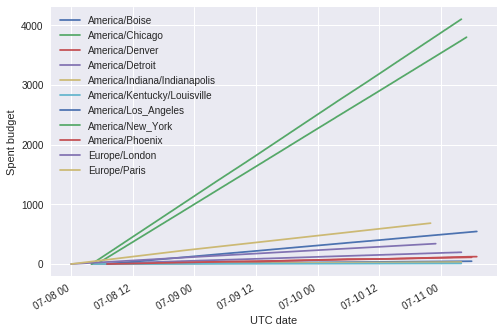

In [44]:
pacing_results.groupby(pacing_results.tz).spent.plot()
plt.legend()
plt.ylabel('Spent budget')
plt.xlabel('UTC date')
plt.savefig('spent_tz1.pdf')

# Test new algo

In [46]:
class Pacing:
    """ The pacing algorithm class
    """

    def __init__(self, total_budget, start_date, end_date, timezone):
        """Class constructor"""
        # Raise errors in parameters
        if total_budget < 0:
            raise ValueError("Budget cannot be negative!")
        if start_date > end_date:
            raise ValueError("Start date cannot be later than end date!")

        # Fixed attributes
        self.tz = pytz.timezone(timezone)
        self.start_date = self.tz.localize(start_date)
        self.end_date = self.tz.localize(end_date + timedelta(days=1))
        self.total_days = (self.end_date - self.start_date).days
        # Initialize variables for the first day
        self.budget_objective = total_budget
        self.budget_engaged = 0
        self.budget_spent_total = 0
        self.budget_remaining = self.budget_objective - (
            self.budget_engaged + self.budget_spent_total)
        self.building = list()
        self.building_data = pd.DataFrame.from_records(self.building)
        self.remaining_days = (self.end_date - self.start_date).days
        self.current_hour = -1
        self.budget_remaining_hourly = 0
        self.budget_daily = self.budget_remaining / self.remaining_days
        self.surplus_hour = 0
        self.BT = [0]
        self.acceleration = [{'ts': self.start_date,
                              'A': 0}]
        self.speed = [{'ts': self.start_date,
                       'S': 0}]
        self.size_acceleration = 1
        self.sum_acceleration = 0
        self.size_speed = 1
        self.sum_speed = 0
        self.prop_table, self.unif, self.without_weekday = self.meta_prop(self.building_data)
        # Setup variables to begin pacing
        self.day = self.start_date.day
        self.nb_br = 0
        self.nb_buy = 0
        self.prop_purchase = 0
        self.spent_per_sec = 0
        self.new_objective = None
        self.trigger_count = False
        self.surplus_hour = 0
        self.spent_hour = 0
        self.block_increase = False
        self.first_br = True
        self.first_day = True

    @staticmethod
    def gen_prop_lr(br_object):
        """Linear regression with hours and weekdays"""
        aggr = br_object.imps.groupby([br_object.index.date, br_object.index.weekday, br_object.index.hour]).sum()
        aggr.index.names = ['date', 'weekday', 'hour']
        aggr = aggr.reset_index()
        model = ols('imps ~ C(weekday) + C(hour)', data=aggr).fit()
        weekday_list = range(7)
        weekday_list = list(itertools.chain.from_iterable(itertools.repeat(x, 24) for x in weekday_list))
        hour_list = list()
        for i in range(7):
            for z in range(24):
                hour_list.append(z)
        df_fitting = pd.DataFrame({'weekday': weekday_list, 'hour': hour_list})
        prediction = model.predict(df_fitting)
        df_fitting['fitted'] = prediction
        pattern = df_fitting.pivot_table('fitted', index=df_fitting.hour, columns=df_fitting.weekday)
        line, col = pattern.shape
        for i in range(col):
            pattern.iloc[:, i] = pattern.iloc[:, i] * 100 / pattern.iloc[:, i].sum()
        return pattern

    @staticmethod
    def gen_prop_lr_hour(br_object):
        """Linear regression with only hours"""
        aggr = br_object.imps.groupby([br_object.index.date, br_object.index.hour]).sum().reset_index()
        aggr.columns = ['date', 'hour', 'imps']
        model = ols('imps ~ C(hour)', data=aggr).fit()
        hour_list = list()
        for z in range(24):
            hour_list.append(z)
        df_fitting = pd.DataFrame({'hour': hour_list})
        prediction = model.predict(df_fitting)
        df_fitting['fitted'] = prediction
        df_fitting.index = df_fitting.hour
        del df_fitting['hour']
        df_fitting.iloc[:, 0] = df_fitting.iloc[:, 0] * 100 / df_fitting.iloc[:, 0].sum()
        return df_fitting

    def meta_prop(self, data):
        """ Give the proportion of impressions per hour. The output type depends on the input.

        :param data: a dataframe with a datetime as index
        :return: an  integer, a Serie or a Dataframe
        """
        if data.empty:
            unif = True
            without_weekday = True
            prop = 1 / 24
        elif set(data.index.hour.unique()) != set(range(24)):
            unif = True
            without_weekday = True
            prop = 1 / 24
        else:
            if set(data.index.weekday.unique()) != set(range(7)):
                unif = False
                without_weekday = True
                prop = self.gen_prop_lr_hour(data)
            else:
                unif = False
                without_weekday = False
                prop = self.gen_prop_lr(data)
        return prop, unif, without_weekday

    def day_reset(self, ts):
        """ Reset variables when there is a new day
        """
        day = ts.day
        month = ts.month
        year = ts.year
        self.remaining_days = (self.end_date - ts).days + 1  # +1 because biased calculation of days
        if not self.building:
            self.building_data = pd.DataFrame.from_records(self.building)
        else:
            self.first_day = False
            self.building_data = pd.DataFrame.from_records(self.building, index='Date')
        self.current_hour = -1
        self.budget_remaining_hourly = 0
        self.budget_daily = self.budget_remaining / self.remaining_days
        self.surplus_hour = 0
        self.BT = [0]
        self.acceleration = [{'ts': self.tz.localize(datetime(year, month, day, 0, 0, 0)),
                              'A': 0}]
        self.speed = [{'ts': self.tz.localize(datetime(year, month, day, 0, 0, 0)),
                       'S': 0}]
        self.size_acceleration = 1
        self.sum_acceleration = 0
        self.size_speed = 1
        self.sum_speed = 0
        self.prop_table, self.unif, self.without_weekday = self.meta_prop(self.building_data)

    def hour_reset(self, weekday):
        """ Reset budget for the following hour
        """
        self.current_hour += 1
        self.remaining_hours = 24 - self.current_hour
        # Evolutive target
        self.surplus_hour += self.budget_remaining_hourly / self.remaining_hours
        if self.unif:
            self.budget_hour = (self.prop_table * self.budget_daily) + self.surplus_hour
        elif self.without_weekday and not self.unif:
            self.budget_hour = (self.prop_table.iloc[
                                    self.current_hour, 0] / 100) * self.budget_daily + self.surplus_hour
        else:
            self.budget_hour = (self.prop_table.iloc[
                                    self.current_hour, weekday] / 100) * self.budget_daily + self.surplus_hour
        self.target = self.budget_hour / 3600
        self.spent_hour = 0
        self.budget_remaining_hourly = self.budget_hour - self.spent_hour

    def gen_mean(self, mean_type):
        """ Return the average variation and speed of variation for bt
        """
        created_time = self.acceleration[-1]['ts'] - timedelta(minutes=30)
        if mean_type == 'acceleration':
            while self.acceleration[0]['ts'] < created_time:
                self.size_acceleration -= 1
                self.sum_acceleration += self.acceleration[0]['A']
                del self.acceleration[0]
            try:
                average = self.sum_acceleration / self.size_acceleration
            except ZeroDivisionError:
                average = 0
        else:
            while self.speed[0]['ts'] < created_time:
                self.size_speed -= 1
                self.sum_speed += self.speed[0]['S']
                del self.speed[0]
            try:
                average = self.sum_speed / self.size_speed
            except ZeroDivisionError:
                average = 0
        return average

    def build_data_prop(self, ts, imps):
        self.building.append({'Date': ts, 'imps': imps})

    def bt_calculation(self, average_acceleration, average_speed, remaining_time, coef=1):
        """ Return the per second budget
        """
        alpha = average_acceleration * coef
        try:
            bt = self.budget_remaining_hourly * ((1 + alpha * average_speed) / remaining_time)
        except ZeroDivisionError:
            bt = 1
        if bt < 0:
            bt = 1
        return bt

    def buying_decision(self, ts, price, imps):
        """From a BR, decide whether to buy or not

        :param ts: timestamp of the BR
        :param price: price of the BR
        :param imps: number of impressions
        :return: Boolean
        """

        # Check problem in br
        if price < 0:
            return False
        if imps < 0:
            return False
        
        if self.first_br:
            self.first_br = False
            self.ts_first_br = datetime.timestamp(ts) 
        
        # Enough time to check proportion
        if datetime.timestamp(ts) - self.ts_first_br >= 3600:
            self.trigger_count = True
            
        # TS de la BR
        self.weekday = ts.weekday()
        day = ts.day
        month = ts.month
        year = ts.year
        hour = ts.hour

        # If we begin a new day, we reset variables
        if self.day != day:
            self.day_reset(ts)
        self.day = day

        # Changement of hour
        while hour != self.current_hour:
            self.hour_reset(self.weekday)

        # Build data for proportion lr
        self.build_data_prop(ts, imps)

        # Remaining time before the end of the hour
        end_hour = self.tz.localize(datetime(year, month, day, hour, 59, 59, 999999))
        remaining_time = datetime.timestamp(end_hour) - datetime.timestamp(ts)

        # Calculation of bt
        average_acceleration = self.gen_mean('acceleration')
        average_speed = self.gen_mean('speed')
        self.bt = self.bt_calculation(average_acceleration, average_speed, remaining_time)

        # Calculation of vt and at
        self.BT.append(self.bt)
        vt = self.BT[-1] - self.BT[-2]
        self.speed.append({'ts': ts,
                           'S': vt})
        self.size_speed += 1
        at = self.speed[-1]['S'] - self.speed[-2]['S']
        self.acceleration.append({'ts': ts,
                                  'A': at})
        self.size_acceleration += 1

        # Buying decision
        if (self.bt >= self.target) and (self.budget_remaining_hourly - price) >= 0:
            buying = True
            self.budget_engaged += price
            self.spent_hour += price
            self.nb_buy += 1
        else:
            buying = False
        self.budget_remaining_hourly = self.budget_hour - self.spent_hour
        self.budget_remaining = self.budget_objective - (
            self.budget_engaged + self.budget_spent_total)
        if self.budget_remaining < 0:
            self.budget_remaining = 0
        self.nb_br += 1
        
        # Check proportion of bought br
        self.new_objective = self.check_proportion(ts)
        
        return buying
    
    def check_proportion(self, ts):
        self.prop_purchase = self.nb_buy / self.nb_br
        if not self.first_day and self.trigger_count and self.prop_purchase >= 0.7:
            elapsed_time = datetime.timestamp(ts) - datetime.timestamp(self.start_date)
            spent_per_sec = self.budget_spent_total / elapsed_time
            remaining_time = datetime.timestamp(self.end_date) - datetime.timestamp(ts)
            new_objective = (spent_per_sec * remaining_time) * 0.85
            if (self.budget_spent_total + self.budget_engaged) < new_objective < self.budget_objective:
                self.block_increase = True
                self.trigger_count = False
                self.ts_first_br = datetime.timestamp(ts)
                return new_objective
        
    def reallocate_budget(self, new_objective):
        self.budget_objective = new_objective
        self.budget_remaining = self.budget_objective - (
            self.budget_engaged + self.budget_spent_total)
        self.budget_daily = self.budget_remaining / self.remaining_days
        if self.unif:
            self.budget_hour = (self.prop_table * self.budget_daily) + self.surplus_hour
        elif self.without_weekday and not self.unif:
            self.budget_hour = (self.prop_table.iloc[
                                    self.current_hour, 0] / 100) * self.budget_daily + self.surplus_hour
        else:
            self.budget_hour = (self.prop_table.iloc[
                                    self.current_hour, self.weekday] / 100) * self.budget_daily + self.surplus_hour
        self.target = self.budget_hour / 3600
        self.spent_hour = 0
        self.budget_remaining_hourly = self.budget_hour - self.spent_hour  

    def receive_notification(self, status, br_price):
        """ From a notification, take into account the status (win/lose)
        """
        if status == 'win':
            self.budget_engaged -= br_price
            self.budget_spent_total += br_price
        elif status == 'lose':
            self.budget_engaged -= br_price
            self.spent_hour -= br_price
        self.budget_remaining = self.budget_objective - (
            self.budget_engaged + self.budget_spent_total)

In [47]:
def send_pending_notifications(instance_obj, pending_notif, current_ts=None):
    """ Send notifications

    :param instance_obj: instance of the algorithm class
    :param pending_notif: list of notifications
    :param current_ts: if None: will send all notifications, else send before current_ts
    """
    while len(pending_notif) > 0 and (pending_notif[0]['timestamp'] <= current_ts if current_ts else True):
        ev = pending_notif.pop(0)
        instance_obj.dispatch_notifications(ev['id'], ev['status'], ev['br_price'])

In [48]:
class GlobalPacing(object):
    def __init__(self, total_budget, start_date, end_date, tz_list):
        self.total_budget = total_budget
        self.start_date = start_date
        self.end_date = end_date
        self.tz_list = tz_list
        self.tz_objective = self.tz_list.copy()
        self.timezones = {}
        self.prop_tz = pd.Series((1/len(self.tz_list)), index=self.tz_list)
        
        # Initial even repartition
        self.Budget_tz = self.prop_tz * self.total_budget
        
        # Instance creation
        self.instances = {}
        for key in self.tz_list:
            self.instances[key] = Pacing(total_budget=self.Budget_tz[key], 
                                         start_date=self.start_date, 
                                         end_date=self.end_date, timezone=key)
    def choose_pacing(self, ts, tz, price, imps, br_id):
        local_date = datetime.fromtimestamp(ts, tz=pytz.timezone(tz))
        buying = self.instances[tz].buying_decision(local_date, price, imps)
        if buying:
            self.timezones[br_id] = tz
        budget_remaining = self.instances[tz].budget_remaining
        spent_budget = self.instances[tz].budget_spent_total
        budget_engaged = self.instances[tz].budget_engaged
        prop = self.instances[tz].prop_purchase
        if self.instances[tz].new_objective is not None:
            self.set_new_objectives(self.instances[tz].budget_objective, 
                                    self.instances[tz].new_objective, tz)
        objective = self.instances[tz].budget_objective
        return buying, budget_remaining, spent_budget, budget_engaged, objective, prop      
    
    def set_new_objectives(self, old_objective, new_objective, tz):
        for key in self.tz_list:
            # We delete the tz from the list to block the increase 
            if self.instances[key].block_increase:
                try:
                    self.tz_objective.remove(key)
                except ValueError:
                    pass
        # We check if there is at least one timezone to dispatch the surplus budget
        if len(self.tz_objective) > 0:
            surplus_budget = (old_objective - new_objective) / len(self.tz_objective)
            self.instances[tz].reallocate_budget(new_objective)
            for key in self.tz_objective:
                self.instances[key].reallocate_budget(self.instances[key].budget_objective + 
                                                 surplus_budget) 

    def dispatch_notifications(self, br_id, status, br_price):
        tz = self.timezones[br_id]
        del self.timezones[br_id]
        self.instances[tz].receive_notification(status, br_price)
    
    def pacing_performance(self):
        spents = []
        for key in self.tz_list:
            spents.append(self.instances[key].budget_spent_total) 
        return spents

In [49]:
def main(data, budget, day_start, day_end):
    logger.info(f"Start pacing on {len(data)} bid requests")
    tz_list = data.TZ.unique().tolist()
    pacing = GlobalPacing(total_budget=budget, start_date=datetime(2020,7,day_start), 
                    end_date=datetime(2020,7,day_end), tz_list=tz_list)
    records = []
    pending_notifications = []
    for utc, row in data.iterrows():
        tz = row['TZ']
        ts = row['ts']
        local = datetime.fromtimestamp(ts, tz=pytz.timezone(tz))
        
        # Before the campaign?
        if local < pytz.timezone(tz).localize(pacing.start_date):
            continue
            
        # End of the campaign?
        if local > pytz.timezone(tz).localize(pacing.end_date + timedelta(days=1)):
            continue
            
        # Send current notifications
        send_pending_notifications(pacing, pending_notifications, utc)
    
        # Receive BR and make a decision
        buying, budget_remaining, spent_budget, budget_engaged, objective, prop = pacing.choose_pacing(
            ts, tz, row['price'], row['imps'], row['id'])

        # Create notification
        if buying:
            next_notif_ts = utc + timedelta(seconds=row['seconds_notif'])
            status = "win" if row['win'] else "lose"
            br_id = row['id']
            pending_notifications.append(
                {"timestamp": next_notif_ts, "status": status, 
                 "br_price": row['price'], "id": br_id})
            pending_notifications.sort(key=lambda x: x["timestamp"])
        record = {
            'utc_date': utc,
            'local_date': local,
            'tz': tz,
            'buying': buying,
            'remaining': budget_remaining,
            'spent': spent_budget,
            'engaged': budget_engaged,
            'objective': objective,
            'prop':prop
        }
        records.append(record)
    # Send remaining notifications
    send_pending_notifications(pacing, pending_notifications)
    
    # Get pacing performances
    spents = pacing.pacing_performance()

    # Generate result DataFrame
    pacing_df = pd.DataFrame.from_records(records)
    pacing_df.set_index('utc_date', inplace=True)
    logger.info("End of the campaign")
    logger.info(f"Total budget spent: {sum(spents)}")
    logger.info(f"Remaining budget: {budget - sum(spents)}")
    return pacing_df

In [6]:
df = pd.read_pickle('br_clean.pkl')
df.set_index('UTC_date', inplace = True)
df.sort_index(inplace = True)
df['id'] = range(len(df))

In [7]:
df

,local_date,local_hour,ts,TZ,imps,CPM,price,win,seconds_notif,id
UTC_date,,,,,,,,,,
2020-07-08 00:00:00.042,2020-07-07 20:00:00.042000-04:00,20,1.594166e+09,America/New_York,25.037222,9,0.225335,True,4,0
2020-07-08 00:00:00.070,2020-07-07 20:00:00.070000-04:00,20,1.594166e+09,America/New_York,27.289524,9,0.245606,True,32,1
2020-07-08 00:00:00.235,2020-07-07 20:00:00.235000-04:00,20,1.594166e+09,America/Indiana/Indianapolis,14.187500,9,0.127688,True,42,2
2020-07-08 00:00:00.493,2020-07-07 19:00:00.493000-05:00,19,1.594166e+09,America/Chicago,2.755000,9,0.024795,True,6,3
2020-07-08 00:00:00.787,2020-07-08 02:00:00.787000+02:00,2,1.594166e+09,Europe/Paris,1.000000,6,0.006000,True,35,4
...,...,...,...,...,...,...,...,...,...,...
2020-07-15 03:10:10.286,2020-07-14 20:10:10.286000-07:00,20,1.594783e+09,America/Phoenix,2.581984,9,0.023238,True,8,5999995
2020-07-15 03:10:10.384,2020-07-14 22:10:10.384000-05:00,22,1.594783e+09,America/Chicago,1.570079,9,0.014131,True,11,5999996
2020-07-15 03:10:10.558,2020-07-14 23:10:10.558000-04:00,23,1.594783e+09,America/New_York,10.327063,9,0.092944,True,22,5999997


In [42]:
databis = df['2020-07-08':'2020-07-13']

In [50]:
%%time
pacing_results = main(databis, 10000, 9, 12)

2020-09-03 15:45:18.164 | INFO     | __main__:main:2 - Start pacing on 5032312 bid requests
2020-09-03 16:05:00.700 | INFO     | __main__:main:58 - End of the campaign
2020-09-03 16:05:00.732 | INFO     | __main__:main:59 - Total budget spent: 9998.95143415835
2020-09-03 16:05:00.734 | INFO     | __main__:main:60 - Remaining budget: 1.0485658416491788


CPU times: user 19min 50s, sys: 2.44 s, total: 19min 52s
Wall time: 19min 47s


In [51]:
pacing_results.groupby(pacing_results.tz).tail(1)

,local_date,tz,buying,remaining,spent,engaged,objective,prop
utc_date,,,,,,,,
2020-07-12 21:59:59.090,2020-07-12 23:59:59.090000+02:00,Europe/Paris,False,0.000917,535.920000,5.400000e-02,535.974917,0.410120
2020-07-12 22:59:58.029,2020-07-12 23:59:58.029000+01:00,Europe/London,False,0.011059,221.460000,1.800000e-02,221.489059,0.341288
2020-07-13 03:56:48.399,2020-07-12 23:56:48.399000-04:00,America/Kentucky/Louisville,False,0.015604,190.732390,1.054712e-15,190.747994,0.343401
2020-07-13 03:59:48.100,2020-07-12 23:59:48.100000-04:00,America/Indiana/Indianapolis,True,0.634652,1261.691042,6.306190e-01,1262.956314,0.728030
2020-07-13 03:59:52.350,2020-07-12 23:59:52.350000-04:00,America/Detroit,True,0.035940,1262.525790,3.945838e-01,1262.956314,0.111711
2020-07-13 03:59:59.941,2020-07-12 23:59:59.941000-04:00,America/New_York,False,0.002294,1262.690207,2.638123e-01,1262.956314,0.010934
2020-07-13 04:59:59.549,2020-07-12 23:59:59.549000-05:00,America/Chicago,False,0.007852,1262.519618,4.288440e-01,1262.956314,0.012513
2020-07-13 05:59:46.719,2020-07-12 23:59:46.719000-06:00,America/Boise,False,0.006446,211.072681,1.470857e-02,211.093835,0.367333
2020-07-13 05:59:53.294,2020-07-12 23:59:53.294000-06:00,America/Denver,True,0.326579,1262.435667,1.940677e-01,1262.956314,0.506821


/home/thomas/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


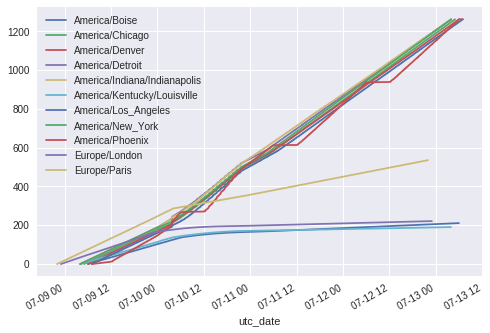

In [52]:
pacing_results.groupby(pacing_results.tz).spent.plot()
plt.legend()

In [116]:
databis.groupby('TZ').agg({'imps':sum})/1000

,imps
TZ,
America/Boise,84.735174
America/Chicago,14840.249738
America/Denver,363.923495
America/Detroit,1664.501815
America/Indiana/Indianapolis,248.208931
America/Kentucky/Louisville,82.805386
America/Los_Angeles,5471.177493
America/New_York,17412.544387
America/Phoenix,1931.876586


In [28]:
verif = databis[databis['TZ']=='America/Indiana/Indianapolis']

In [29]:
verif.set_index('local_date',inplace=True)

In [35]:
verif['2020-07-12'].groupby('local_hour').size()

local_hour
0     115
1     117
2     114
3     113
4     115
5     114
6     114
7     111
8     113
9     117
10    111
11    111
12    112
13    113
14    111
15    111
16    111
17    113
18    110
19    113
dtype: int64